<a href="https://colab.research.google.com/github/Mr-Moore/machine-learning/blob/main/unet_segmentation/04b_unet_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Enable GPU and set up helper functions

In [ ]:
import tensorflow as tf
print(tf.version.VERSION)
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

2.12.0
Found GPU at: /device:GPU:0


# Read Oxford-IIIT Pets dataset

In [ ]:
import tensorflow_datasets as tfds
# with_info: bool, if True, tfds.load will return the tuple (tf.data.Dataset, tfds.core.DatasetInfo), the latter containing the info associated with the builder.
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incomplete8OV0DY/oxford_iiit_pet-train.tfrecord*...:…

Generating test examples...:   0%|          | 0/3669 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incomplete8OV0DY/oxford_iiit_pet-test.tfrecord*...: …

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


In [ ]:
def read_and_preprocess(data):
  input_image = tf.image.resize(data['image'], (128,128))
  input_mask = tf.image.resize(data['segmentation_mask'], (128, 128))

  input_image = tf.image.convert_image_dtype(input_image, tf.float32) # [0, 1]
  input_mask -= 1 # {1, 2, 3} -> {0, 1, 2}

  return input_image, input_mask

In [ ]:
# Mapping consists of applying a transformation function to an iterable to produce a new iterable.
# Items in the new iterable are produced by calling the transformation function on each item in the original iterable.

# https://blog.csdn.net/u014061630/article/details/80776975
train = dataset['train'].map(read_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
test = dataset['test'].map(read_and_preprocess)

# Display some example images and their labels

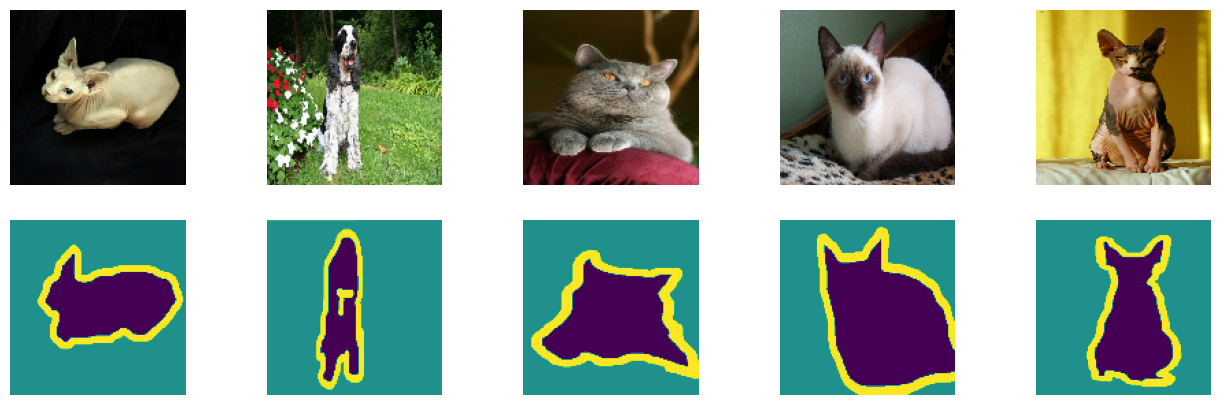

In [ ]:
import matplotlib.pylab as plt
import numpy as np
# when using .subplots() to create a new figure, specify figsize.(圖的大小)
# return fig: Figure. ax: Axes or array of Axes.
f, ax = plt.subplots(2, 5, figsize=(16,5))
for idx, (img, mask) in enumerate(train.take(5)):
  ax[0, idx].imshow(tf.keras.preprocessing.image.array_to_img(img))
  ax[0, idx].axis('off')
  #mask = tf.reshape(mask, [128, 128])
  ax[1, idx].imshow(mask.numpy())
  ax[1, idx].axis('off')

# Modified U-Net


In [ ]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000

def augment(img, mask):
  # tf.random.uniform: need The shape of the output tensor.
  if tf.random.uniform(()) > 0.5:# same as tf.random.uniform([]).
    img = tf.image.flip_left_right(img)
    mask = tf.image.flip_left_right(mask)
  return img, mask

# shuffle: random order.
train_dataset = train.cache().map(augment).shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
# prefetch(): 提前預取存在緩衝區，保持永遠有準備好的資料供運算. buffer_size: 緩衝區大小，若用tf.data.AUTOTUNE則動態調整緩衝區大小.
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

# .cache(): change the type to a cache object, which can save data in 緩存裡.
# print(train.cache())

test_dataset = test.batch(BATCH_SIZE)

In [ ]:
print(train)
print(train.cache())
print(train.cache().map(augment))
print(train.cache().map(augment).shuffle(BUFFER_SIZE))
print(train.cache().map(augment).shuffle(BUFFER_SIZE).batch(BATCH_SIZE))
print(train.cache().map(augment).shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat())
print(train)

<_ParallelMapDataset element_spec=(TensorSpec(shape=(128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(128, 128, 1), dtype=tf.float32, name=None))>
<CacheDataset element_spec=(TensorSpec(shape=(128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(128, 128, 1), dtype=tf.float32, name=None))>
<_MapDataset element_spec=(TensorSpec(shape=(128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(128, 128, 1), dtype=tf.float32, name=None))>
<_ShuffleDataset element_spec=(TensorSpec(shape=(128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(128, 128, 1), dtype=tf.float32, name=None))>
<_BatchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None))>
<_RepeatDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None))>
<_ParallelMapDataset element_spec=(TensorSpec(

In [ ]:
# https://www.tensorflow.org/datasets/splits
TRAIN_LENGTH = info.splits['train'].num_examples
STEPS_PER_EPOCHS = TRAIN_LENGTH // BATCH_SIZE
OUTPUT_CHANNELS = 3

In [ ]:
# include_top: lets you select if you want the final dense layers or not.
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Use the activations of these layers to form skip connections
layers_name = [
  'block_1_expand_relu', #64x64
  'block_3_expand_relu', #32x32
  'block_6_expand_relu', #16x16
  'block_13_expand_relu', # 8x8
  'block_16_project', #4x4
]
# You can easily get the outputs of any layer by using: model.layers[index].output.
base_model_outputs = [base_model.get_layer(name).output for name in layers_name]

# Create the feature extraction model
# outputs: a tensor that originated from keras.Input objects or a combination of such tensors in a dict, list or tuple.
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs,
               name='pretrained_mobilenet')

down_stack.trainable = False

9406464/9406464 [==============================] - 1s 0us/step


In [ ]:
def upsample(filters, size, name):
  # tf.keras.layers.Conv2DTranspose: Transposed convolution layer (sometimes called Deconvolution).
  # filters: Integer, the dimensionality of the output space (i.e. the number of output filters in the convolution).配合課本P169.
  # https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2DTranspose At here kernel_size=size.
  # 課本P164.
  return tf.keras.Sequential([
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2, padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU()
  ], name=name)

up_stack = [
  upsample(512, 3, 'upsample_4x4_to_8x8'),
  upsample(256, 3, 'upsample_8x8_to_16x16'),
  upsample(128, 3, 'upsample_16x16_to_32x32'),
  upsample(64, 3 ,'upsample_32x32_to_64x64')
]

In [ ]:
import re

def unet_model(output_channels):
  inputs = tf.keras.layers.Input(shape=[128, 128, 3], name='input_image')

  # Downsampling through the model.
  skips = down_stack(inputs)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # zip(): 回傳一個迭代器（iterator），而這個迭代器的第i個元素，就是每個傳入引數的第i個內容所組合成的tuple.
  for idx, (up, skip) in enumerate(zip(up_stack, skips)):
    x = up(x)
    # tf.keras.layers.Concatenate(): It takes as input a list of tensors,
    # all of the same shape except for the concatenation axis, and returns a single tensor that is the concatenation of all inputs.
    concat = tf.keras.layers.Concatenate(name='expand_{}'.format(idx))
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
    output_channels, 3, strides=2,
    padding='same') # 64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

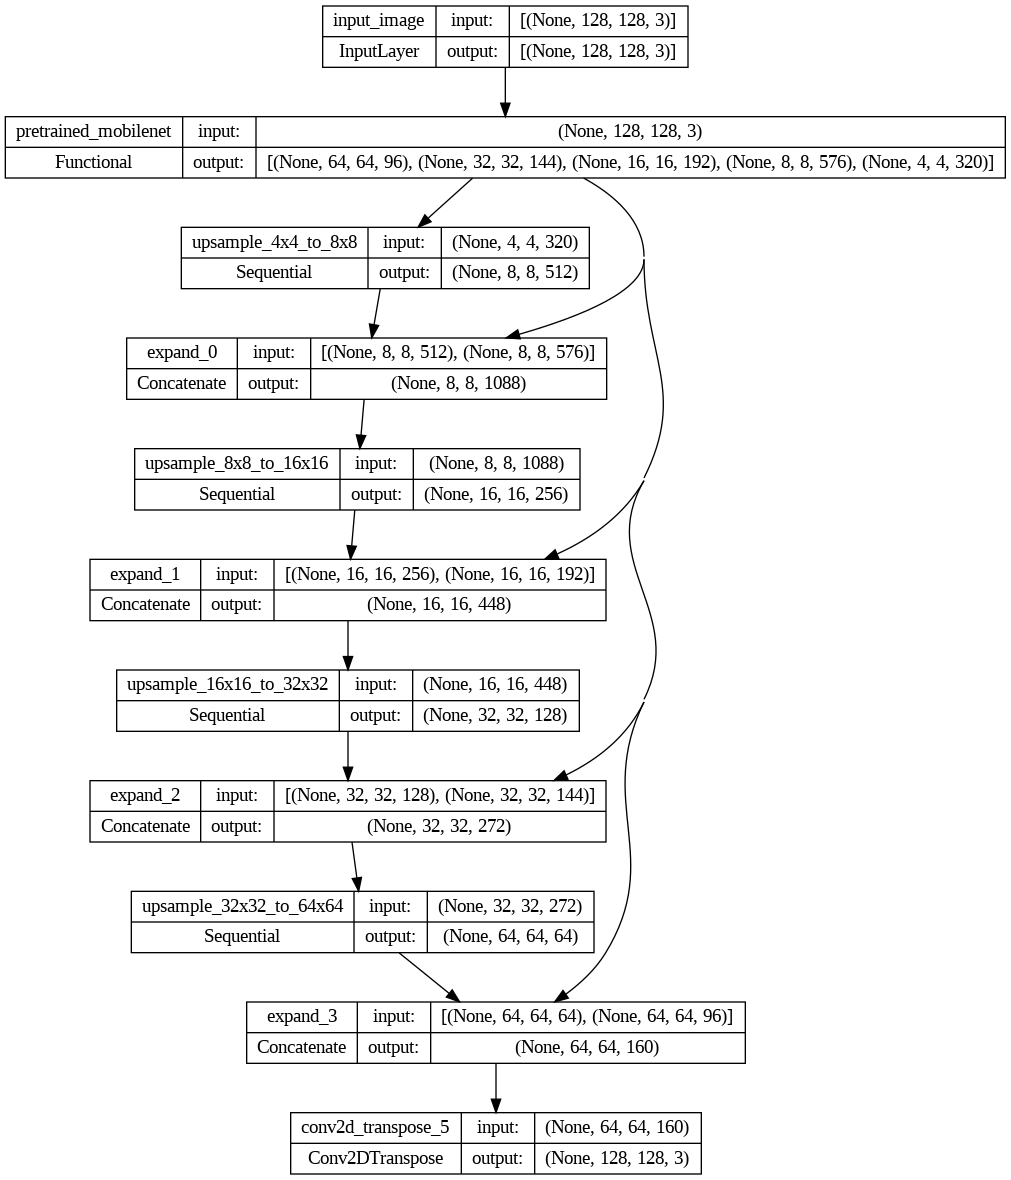

In [ ]:
model = unet_model(OUTPUT_CHANNELS)
# https://www.tensorflow.org/api_docs/python/tf/keras/utils/plot_model
tf.keras.utils.plot_model(model, show_shapes=True)

# Train the Model

We treat this as a multi-class prediction problem. So, the loss function used is SparseCategoricalCrossentropy and the metric is accuracy.

In [ ]:
model = unet_model(OUTPUT_CHANNELS)
model.compile(optimizer='adam',
       loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
       metrics=['accuracy'])

In [ ]:
# Assign to the pixel the label with the highest probability
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  # Add one dimension at certain position.
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

Helper functions to see model output as it is training

In [ ]:
# display helper functions
def display(display_list):
  plt.figure(figsize=(15,15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

def show_predictions(dataset, num):
  for image, mask in dataset.take(num):
    pred_mask = model.predict(image)
    # Using image[0] is because the shape has 4 dimension.
    display([image[0], mask[0], create_mask(pred_mask)])

1/1 [==============================] - 0s 27ms/step


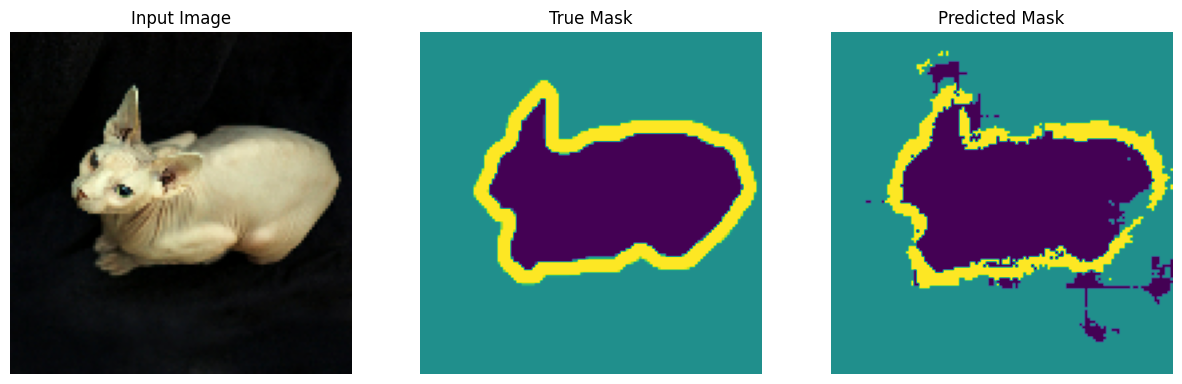

In [ ]:
# before the model is trained
# change second parameter can show more num image.
show_predictions(train.batch(1), 1)

To observe how the model improves while it is training we define a callback function to show the predictions when the epoch finishes.

In [ ]:
# from IPython.display import clear_out
# tf.keras.callbacks.Callback: Abstract base class used to build new callbacks.
# https://www.tensorflow.org/guide/keras/writing_your_own_callbacks custom own callbacks using subclass.
class DisplayCallback(tf.keras.callbacks.Callback):
  # on_epoch_end(self, epoch, logs=None): Called at the end of an epoch during training.
  def on_epoch_end(self, epoch, logs=None):
    if epoch%5 == 0:
      # clear_output: bool If True, clear the content of the output widget at every new function call.
      # clear_output(wait=True) # if you want replace the images each time, uncomment this
      show_predictions(train.batch(1), 2)
      # epoch run from 0 -> max-1.
      print('\nSample Prediction after epoch {}\n'.format(epoch+1))

Epoch 1/20
1/1 [==============================] - 0s 24ms/step


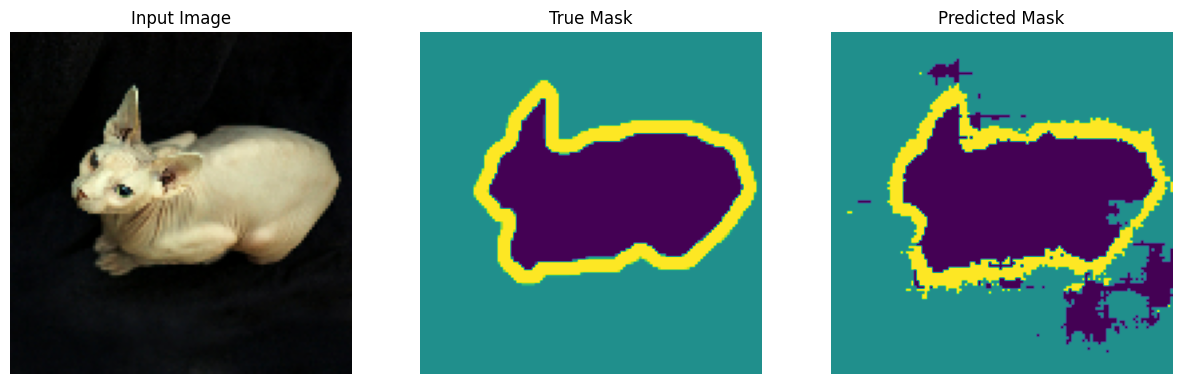

1/1 [==============================] - 0s 24ms/step


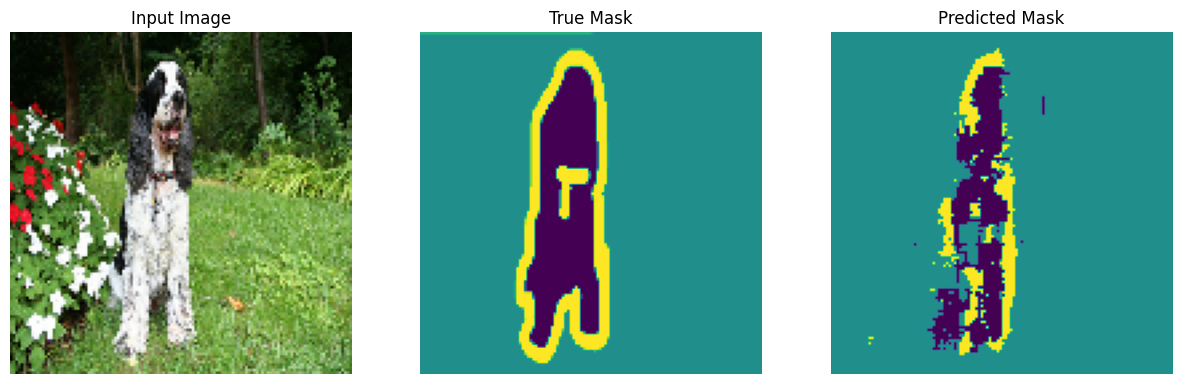


Sample Prediction after epoch 1

57/57 [==============================] - 3s 44ms/step - loss: 0.4524 - accuracy: 0.8109 - val_loss: 0.5331 - val_accuracy: 0.7792
Epoch 2/20
57/57 [==============================] - 2s 30ms/step - loss: 0.4524 - accuracy: 0.8110 - val_loss: 0.5326 - val_accuracy: 0.7815
Epoch 3/20
57/57 [==============================] - 2s 30ms/step - loss: 0.4462 - accuracy: 0.8134 - val_loss: 0.5366 - val_accuracy: 0.7834
Epoch 4/20
57/57 [==============================] - 2s 29ms/step - loss: 0.4437 - accuracy: 0.8141 - val_loss: 0.5372 - val_accuracy: 0.7839
Epoch 5/20
57/57 [==============================] - 2s 29ms/step - loss: 0.4406 - accuracy: 0.8156 - val_loss: 0.5408 - val_accuracy: 0.7809
Epoch 6/20
1/1 [==============================] - 0s 25ms/step


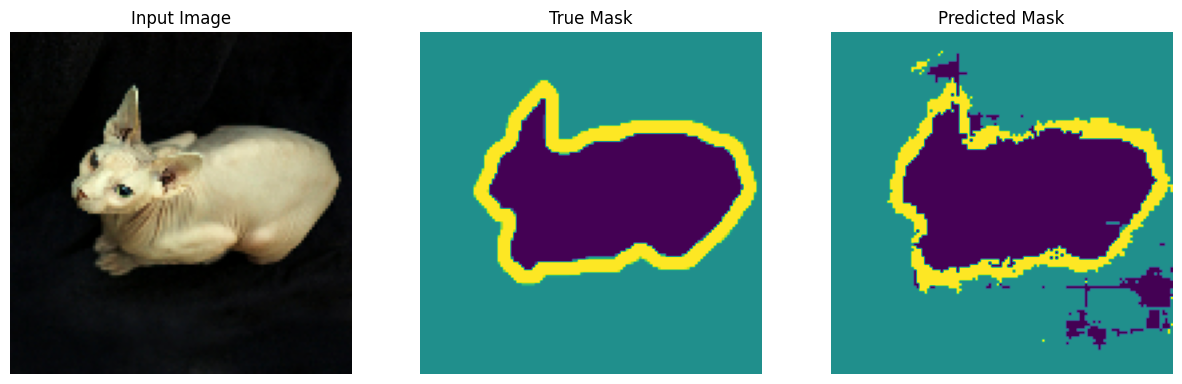

1/1 [==============================] - 0s 24ms/step


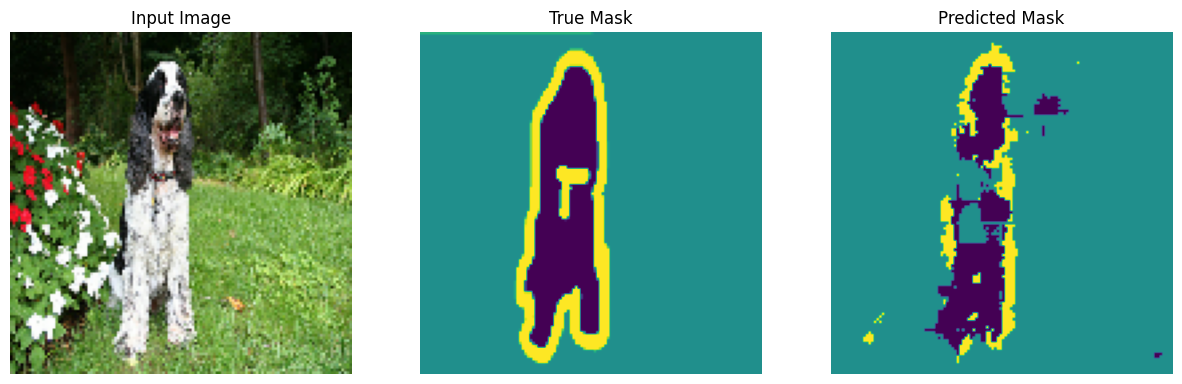


Sample Prediction after epoch 6

57/57 [==============================] - 2s 44ms/step - loss: 0.4368 - accuracy: 0.8171 - val_loss: 0.5321 - val_accuracy: 0.7812
Epoch 7/20
57/57 [==============================] - 2s 29ms/step - loss: 0.4360 - accuracy: 0.8173 - val_loss: 0.5618 - val_accuracy: 0.7721
Epoch 8/20
57/57 [==============================] - 2s 29ms/step - loss: 0.4276 - accuracy: 0.8207 - val_loss: 0.5483 - val_accuracy: 0.7787
Epoch 9/20
57/57 [==============================] - 2s 29ms/step - loss: 0.4250 - accuracy: 0.8221 - val_loss: 0.5539 - val_accuracy: 0.7748
Epoch 10/20
57/57 [==============================] - 2s 28ms/step - loss: 0.4216 - accuracy: 0.8233 - val_loss: 0.5440 - val_accuracy: 0.7832
Epoch 11/20
1/1 [==============================] - 0s 25ms/step


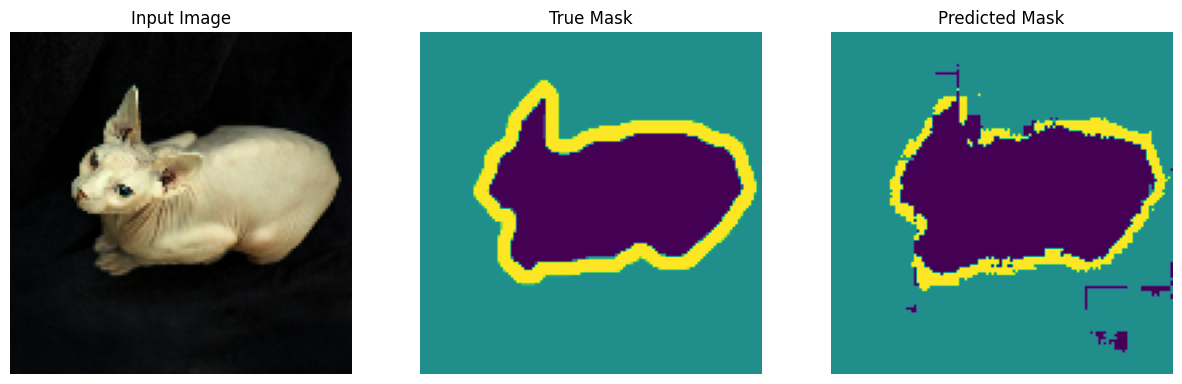

1/1 [==============================] - 0s 24ms/step


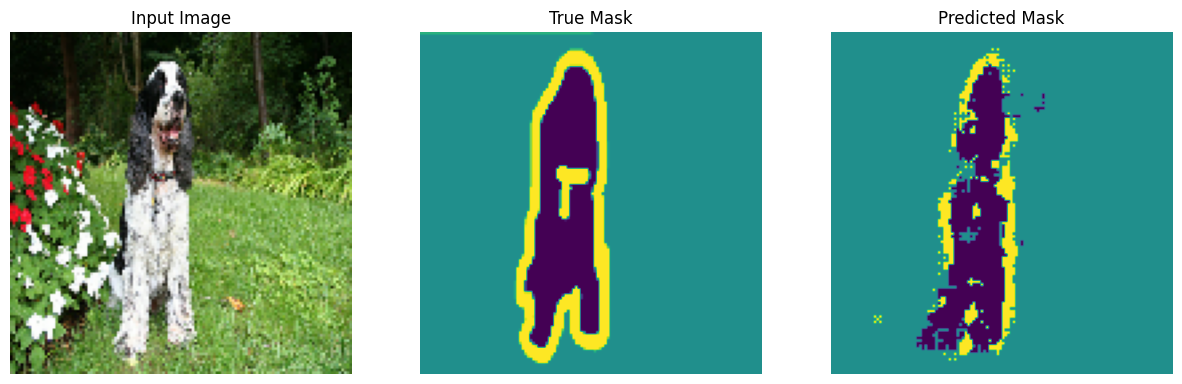


Sample Prediction after epoch 11

57/57 [==============================] - 2s 43ms/step - loss: 0.4101 - accuracy: 0.8279 - val_loss: 0.5436 - val_accuracy: 0.7826
Epoch 12/20
57/57 [==============================] - 2s 29ms/step - loss: 0.4121 - accuracy: 0.8274 - val_loss: 0.5520 - val_accuracy: 0.7817
Epoch 13/20
57/57 [==============================] - 2s 34ms/step - loss: 0.4142 - accuracy: 0.8261 - val_loss: 0.5430 - val_accuracy: 0.7807
Epoch 14/20
57/57 [==============================] - 2s 29ms/step - loss: 0.4016 - accuracy: 0.8317 - val_loss: 0.5500 - val_accuracy: 0.7822
Epoch 15/20
57/57 [==============================] - 2s 29ms/step - loss: 0.4038 - accuracy: 0.8307 - val_loss: 0.5558 - val_accuracy: 0.7823
Epoch 16/20
1/1 [==============================] - 0s 24ms/step


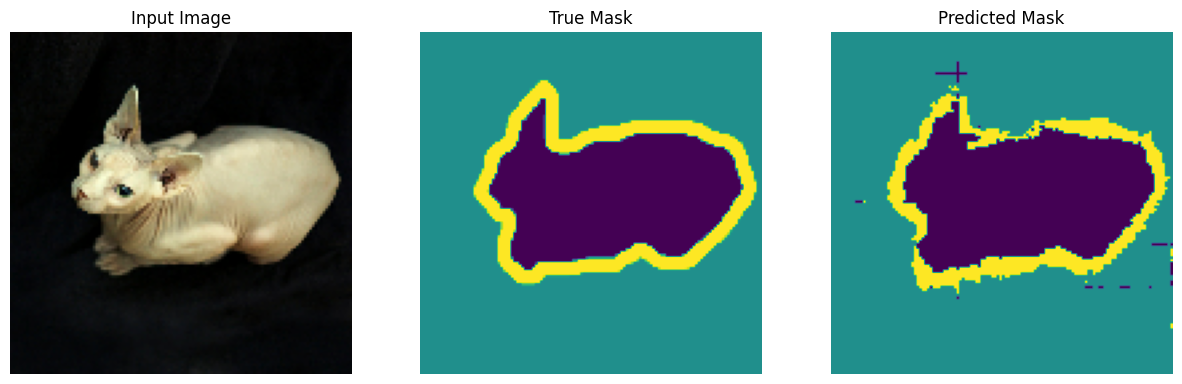

1/1 [==============================] - 0s 25ms/step


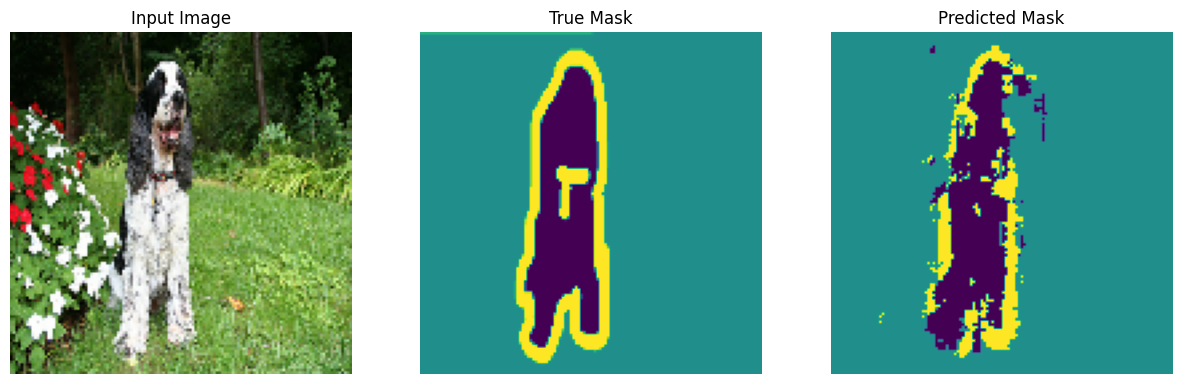


Sample Prediction after epoch 16

57/57 [==============================] - 2s 43ms/step - loss: 0.4006 - accuracy: 0.8316 - val_loss: 0.5492 - val_accuracy: 0.7832
Epoch 17/20
57/57 [==============================] - 2s 29ms/step - loss: 0.3939 - accuracy: 0.8345 - val_loss: 0.5557 - val_accuracy: 0.7822
Epoch 18/20
57/57 [==============================] - 2s 29ms/step - loss: 0.3873 - accuracy: 0.8373 - val_loss: 0.5559 - val_accuracy: 0.7817
Epoch 19/20
57/57 [==============================] - 2s 29ms/step - loss: 0.3821 - accuracy: 0.8391 - val_loss: 0.5586 - val_accuracy: 0.7822
Epoch 20/20
57/57 [==============================] - 2s 29ms/step - loss: 0.3833 - accuracy: 0.8388 - val_loss: 0.5677 - val_accuracy: 0.7845


In [ ]:
EPOCHS = 20
VAL_SUBSPLITS = 5
# You can also do info.splits.total_num_examples to get the total number of examples in the dataset.
VALIDATION_STEPS = info.splits['test'].num_examples // BATCH_SIZE //VAL_SUBSPLITS

model_history = model.fit(train_dataset, epochs=EPOCHS,
              steps_per_epoch=STEPS_PER_EPOCHS,
              validation_steps=VALIDATION_STEPS,
              validation_data=test_dataset,
              callbacks=[DisplayCallback()])

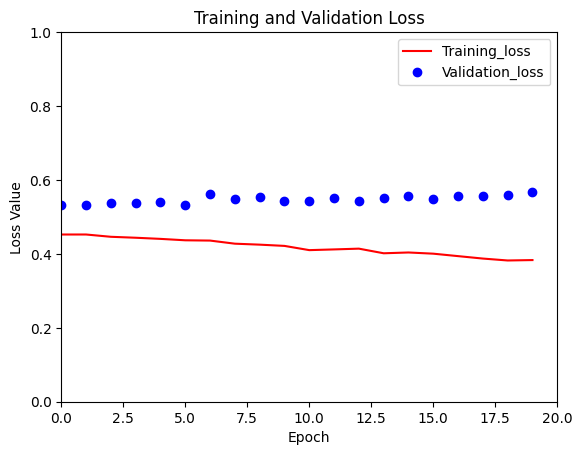

In [ ]:
loss = model.history.history['loss']
val_loss = model.history.history['val_loss']

epochs = range(EPOCHS)

#print(type(epochs))
plt.figure()
plt.plot(epochs, loss, 'r', label='Training_loss')
plt.plot(epochs, val_loss, 'bo', label='Validation_loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0,1])
plt.xlim([0,20])
plt.legend()
plt.show()

To improve the performance further:

  · Train longer

  · Use Mask-R CNN (next notebook)